In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from scipy.optimize import minimize
from datetime import timedelta

In [33]:
df = pd.read_csv("data/SPY_minute.csv",skiprows=1)
datetimes = pd.to_datetime(df.Dates[1:], format='%m/%d/%y %H:%M')
df["Dates"][1:] = datetimes
df["Dates"][0] = df["Dates"][1] - timedelta(minutes=1)
df["log_ret"] = np.log(df["Close"]) - np.log(df.shift(1)["Close"])
df = df.dropna()


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [34]:
# Group data by date
from collections import defaultdict
ret_by_date = defaultdict(list)
for i in range(len(df)):
    ret_by_date[df["Dates"].iloc[i].date()].append(df["log_ret"].iloc[i])

    

In [35]:


def get_neg_log_lik(data, dist, kw):
    return lambda params: -1 * np.sum(dist.logpdf(data, **{kw[i] : params[i] for i in range(len(params))}))

def optim(log_lik, x0, opt='SLSQP'):
    return minimize(neg_log_lik, x0,method=opt)

# neg_log_lik = get_neg_log_lik(log_ret, norm, ['loc', 'scale'])
# optim(neg_log_lik, [0, 1])

In [37]:
# Run MLE each day
pars = []
for date, rets in ret_by_date.items():
    neg_log_lik = get_neg_log_lik(rets, t, ['df', 'loc', 'scale'])
    pars.append(optim(neg_log_lik, [3, 0, 1], opt='nelder-mead').x)
res = pd.DataFrame(pars)
res = res.rename(columns={0:"df", 1:"mu", 2:"sigma"})
res.index = ret_by_date.keys()
res.to_csv("data/pars_t_daily_spy.csv")

In [24]:
generated_data = np.random.normal(loc=2, scale=3, size=100)
kw = ['loc', 'scale']
params = [1,3]
dict(zip(kw,params))

{'loc': 1, 'scale': 3}

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def load_data():
    df = pd.read_csv(
    'E-mini S&P 500 minute data (2 days).csv', header=1)
    cols = ["Date Time", "Close"]
    data = df[cols]
    data = data.set_axis(["timestamp", "close"], axis=1)
    return data


def deltas():
    df = load_data()
    df["log"] = np.log(df["close"].astype(float))
    df["deltas"] = df["log"].diff()
    df.dropna(inplace=True)
    final_data = df[["timestamp", "close", "deltas"]]
    #final_data = final_data.set_axis(["timestamp", "close", "deltas"], axis=1)
    return final_data

In [8]:
data = deltas()
feb_09 = data[(data['timestamp'] >= '2022-02-09') & (data['timestamp'] < '2022-02-10')]

(array([  2.,   0.,   6.,   3.,   3.,   6.,  22.,  35.,  95., 220., 284.,
        144.,  61.,  28.,  18.,   7.,   5.,   1.,   1.,   4.]),
 array([-1.09487064e-03, -9.85506173e-04, -8.76141704e-04, -7.66777236e-04,
        -6.57412768e-04, -5.48048300e-04, -4.38683832e-04, -3.29319363e-04,
        -2.19954895e-04, -1.10590427e-04, -1.22595874e-06,  1.08138509e-04,
         2.17502978e-04,  3.26867446e-04,  4.36231914e-04,  5.45596382e-04,
         6.54960851e-04,  7.64325319e-04,  8.73689787e-04,  9.83054255e-04,
         1.09241872e-03]),
 <BarContainer object of 20 artists>)

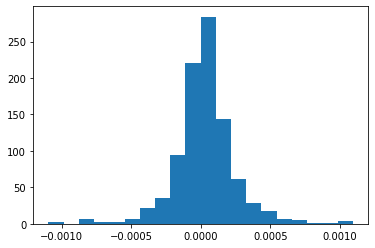

In [11]:
plt.hist(feb_09['deltas'], bins=20)

In [17]:
neg_log_lik = get_neg_log_lik(feb_09['deltas'], norm, ['loc', 'scale'])
res = optim(neg_log_lik, [0, 0.001], opt='nelder-mead')

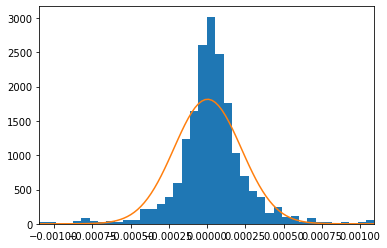

In [18]:
arr = feb_09['deltas']
plt.hist(arr, bins=40, density=True)
plt.xlim((min(arr), max(arr)))
x = np.linspace(min(arr), max(arr), 100)
plt.plot(x, norm.pdf(x, res.x[0], res.x[1]))
plt.show()